# AfSIS Soil Chemistry Dataset - Modelling¶



## 1. Load libraries and data

In [43]:
import pandas as pd
from sys import stdout
#from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.ridge import RidgeCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm
import numpy as np
import time
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image

from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_composition = pd.read_csv('complete_elemental_analysis_dataset.csv')
df_composition.head()

,SSN,pH,%N,%C,C % Inorg,C % Org,Am Ox_Al mg/kg,Am Ox-Fe mg/kg,AmOx-Mn/mg/kg,AmOx-Pmg/kg,...,Fe,Mn,Mo,Public,Latitude,Longitude,Cluster,Plot,Depth,Cultivated
0,icr006454,7.85,0.08,0.95,0.0,0.94,2105.973713,868.347797,160.462825,27.456545,...,1.16865,0.02010,0.01845,True,-6.12601,36.440201,1,1,top,True
1,icr006455,8.03,0.06,0.81,0.1,0.70,2703.686191,1095.670284,185.252606,48.309930,...,1.59154,0.02566,0.01845,True,-6.12601,36.440201,1,1,sub,True
2,icr006474,5.01,0.05,0.57,0.0,0.57,1554.842158,949.235199,52.608644,22.887339,...,0.88799,0.00792,0.01845,True,-6.08875,36.435982,2,1,top,False
3,icr006475,4.57,0.05,0.47,0.0,0.47,1846.889773,1070.019199,33.656658,9.381672,...,1.25013,0.00819,0.01845,True,-6.08875,36.435982,2,1,sub,False
4,icr006492,6.78,0.09,0.98,0.0,0.98,1871.559305,1204.912035,172.634574,32.109882,...,1.48940,0.01938,0.01845,True,-6.06394,36.440500,3,1,top,False


## 2. Elemental analysis and soil fertility

### 2.1 Soil chemistry variables correlation

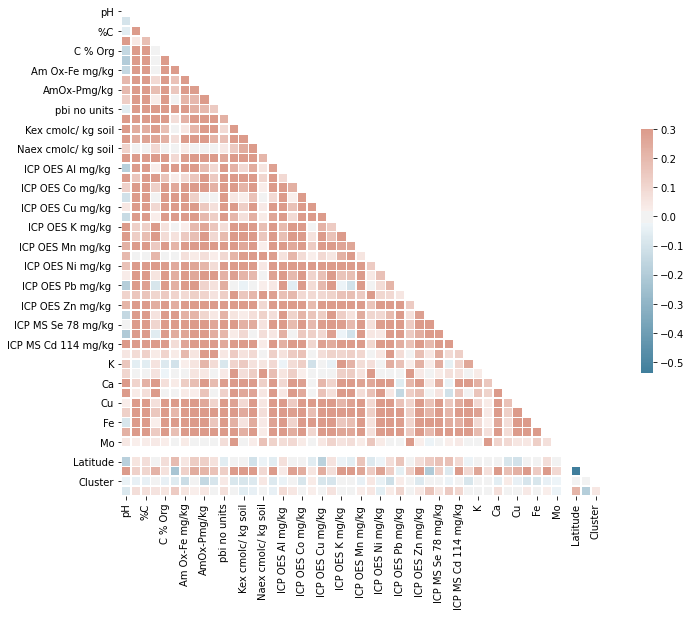

In [3]:
# Compute the correlation matrix
corr = df_composition.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The figures show poor correlation. Surprising that this is true comparing the same element concentration estimated using ICP Optical Emission Spectrometry (ICP-OES-K) and X-rays fluorescence (K)

### 2.2 Composition - fertility correlation

#### 2.2.1 Features selection

In [4]:
elemental_variables = ['pH', '%N', 'P', 'K', 'Ca','Cu','Fe', 'Mo', 'Depth', 'Cultivated']

df_composition_reduced = df_composition[elemental_variables]
df_composition_reduced = df_composition_reduced.rename(columns={"P": "%P", "K": "%K","Ca": "%Ca", "Cu": "%Cu", "Fe": "%Fe", "Mo": "%Mo"})
df_composition_reduced.head()

,pH,%N,%P,%K,%Ca,%Cu,%Fe,%Mo,Depth,Cultivated
0,7.85,0.08,0.00506,1.59260,0.44832,0.00098,1.16865,0.01845,top,True
1,8.03,0.06,0.00506,2.04214,0.90155,0.00124,1.59154,0.01845,sub,True
2,5.01,0.05,0.00506,1.28172,0.08998,0.00093,0.88799,0.01845,top,False
3,4.57,0.05,0.00506,1.29913,0.09441,0.00130,1.25013,0.01845,sub,False
4,6.78,0.09,0.00506,2.21456,0.76517,0.00144,1.48940,0.01845,top,False


#### 2.2.2 Categorical features encoding

In [5]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)# label encoded values of depth
enc_df = pd.DataFrame(enc.fit_transform(df_composition_reduced[['Depth']]), columns = ['depth_sub','depth_top'])

df_composition_reduced = pd.merge(df_composition_reduced, enc_df, left_index=True, right_index=True)
df_composition_reduced = df_composition_reduced.reset_index(drop = True)


In [6]:
df_composition_cultivated  = df_composition_reduced[df_composition_reduced['Cultivated'] != "unknown"]  # eliminate unknown values
print(df_composition_cultivated['Cultivated'].unique())

['True' 'False']


In [7]:
# creating instance of labelencoder for the column "Cultivated"
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])

print(df_composition_cultivated.shape)
df_composition_cultivated = df_composition_cultivated.drop(['Depth', 'Cultivated'], axis = 1)

(148, 13)


<ipython-input-7-d4eb68b28776>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])


In [8]:
df_composition_cultivated.head()

,pH,%N,%P,%K,%Ca,%Cu,%Fe,%Mo,depth_sub,depth_top,Cultivated_n
0,7.85,0.08,0.00506,1.59260,0.44832,0.00098,1.16865,0.01845,0.0,1.0,1
1,8.03,0.06,0.00506,2.04214,0.90155,0.00124,1.59154,0.01845,1.0,0.0,1
2,5.01,0.05,0.00506,1.28172,0.08998,0.00093,0.88799,0.01845,0.0,1.0,0
3,4.57,0.05,0.00506,1.29913,0.09441,0.00130,1.25013,0.01845,1.0,0.0,0
4,6.78,0.09,0.00506,2.21456,0.76517,0.00144,1.48940,0.01845,0.0,1.0,0


#### 2.2.3 Data modeling - logistic regression

In [9]:

X_cultivated = df_composition_cultivated.drop(['Cultivated_n'], axis = 1).values[:, 1:]

X_cult_scaled = StandardScaler().fit_transform(X_cultivated) # scale those features
y_cultivated = df_composition_cultivated['Cultivated_n'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X_cult_scaled, y_cultivated, test_size = 0.2, random_state = 42)

In [10]:
lr_cultivated = LogisticRegression(solver='liblinear',dual=True, random_state=42)

lr_cultivated.fit(X1_train, y1_train)
y1_pred = lr_cultivated.predict(X1_test) # estimation of cultivated value based on fit
accuracy_lr = lr_cultivated.score(X1_test, y1_test)
print('Score of the logistic regression model for soil composition and fertility = ',np.round(accuracy_lr,2))

Score of the logistic regression model for soil composition and fertility =  0.83


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [11]:
cm1 = confusion_matrix(y1_test, y1_pred)

print(classification_report(y1_test, y1_pred))

df_confusionmatrix1 = pd.DataFrame(data=cm1, index=["actual negative","actual positive"], columns=["predicted negative","predicted positive"])
df_confusionmatrix1 

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.50      0.20      0.29         5

    accuracy                           0.83        30
   macro avg       0.68      0.58      0.60        30
weighted avg       0.80      0.83      0.80        30



,predicted negative,predicted positive
actual negative,24,1
actual positive,4,1


In [12]:
 # Cross-validation
y_cv = cross_val_predict(lr_cultivated, X1_test, y1_test, cv=5)
scores = cross_val_score(lr_cultivated, X1_test, y1_test, cv=5)
scores

array([0.83333333, 0.66666667, 0.83333333, 0.83333333, 0.83333333])

Logistic Regression: 1-dimensional representation


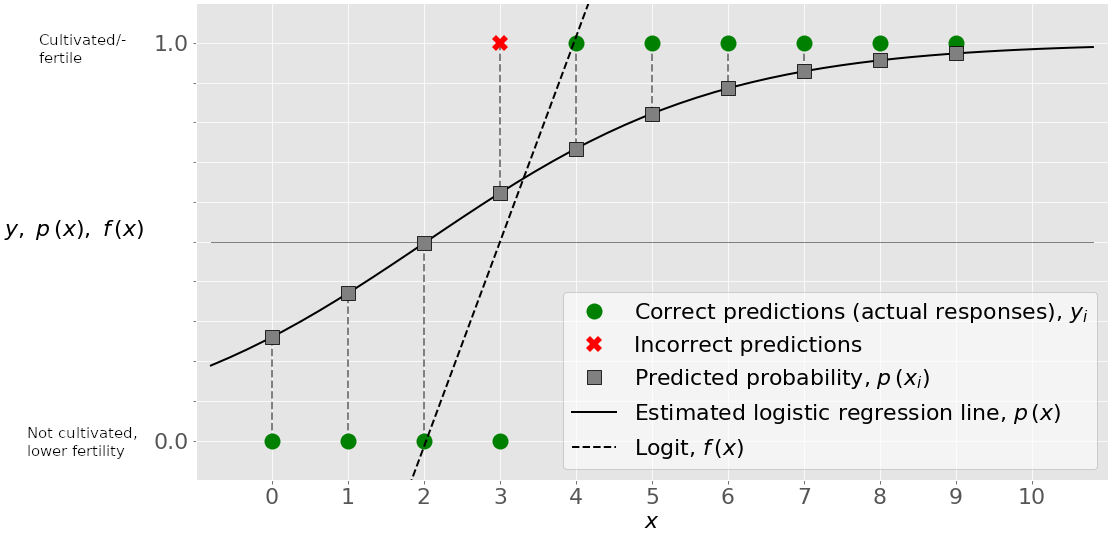

In [13]:
print("Logistic Regression: 1-dimensional representation")
Image(filename='img/logisticregression.png') 

In [14]:
n_components = 5

pca = PCA(n_components= n_components)
principalComponents = pca.fit_transform(X_cult_scaled)

df_PCA_composition = pd.DataFrame(data = principalComponents , columns = ['compositional_component1','compositional_component2','compositional_component3','compositional_component4','compositional_component5'])


print('the new component contains',pca.explained_variance_ratio_ * 100, '% of the information from the', n_components ,'variables', 'for a total of',sum(pca.explained_variance_ratio_ * 100),'%' )
#

the new component contains [34.20084009 24.16095274 13.21891691 11.05440897  7.2655904 ] % of the information from the 5 variables for a total of 89.90070911585444 %


## 3. Elemental analysis - Infrared spectroscopy correlation

### 3.1 Loading infrared spectra and target variables

In [15]:
df_FTIR = pd.read_csv('complete_analysis_NIR.csv')
df_FTIR_sp = df_FTIR.drop(['SSN'], axis=1)
print(df_FTIR_sp.shape)

(467, 907)


In [16]:
# Get wavelengths
wavelenghts_list = df_FTIR_sp.columns.tolist() 
wavelenghts = np.array(wavelenghts_list)
print(len(wavelenghts))


907


In [17]:
X = df_FTIR_sp.values

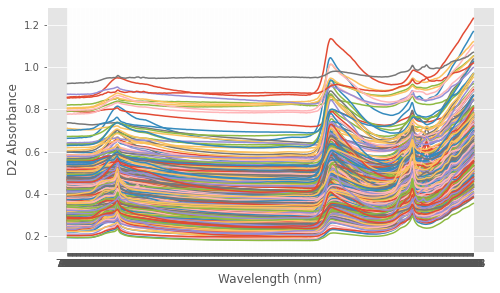

In [18]:
# Plot all spectra
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavelenghts, X.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

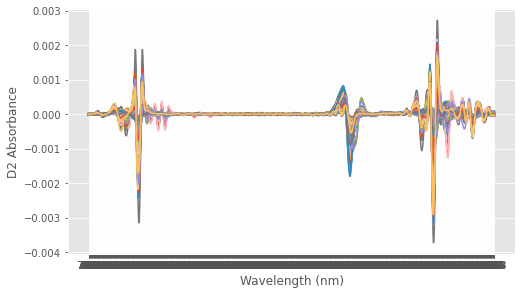

In [19]:
# Calculate second derivative
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)

# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavelenghts, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [20]:
df_composition_reduced.columns

Index(['pH', '%N', '%P', '%K', '%Ca', '%Cu', '%Fe', '%Mo', 'Depth',
       'Cultivated', 'depth_sub', 'depth_top'],
      dtype='object')

In [21]:
#PLS1 - single feature regression
target_feature = ['%N'] #[, '%P', '%K']#, '%Ca', '%Cu', '%Fe', '%Mo','pH'
#PLS2 - multiple features regression
target_features = ['%N', '%P', '%K']#, '%Ca', '%Cu', '%Fe', '%Mo','pH']

y2 = df_composition_reduced[target_feature].values #PLS1 - single feature regression
Y2 = df_composition_reduced[target_features].values #PLS2 - multiple features regression
print('shapes verification',y2.shape, Y2.shape)

shapes verification (467, 1) (467, 3)


### 3.2 Multivariate partial least squares (PLS) regression
#### PLS1: univariate target 

Here's the main function. It first runs a loop over the number of PLS components and calculate the MSE of prediction. Secondly, it seeks the number of components that minimises the MSE and uses that value to run a PLS again. The second time around, a whole bunch of metrics is calculated and printed. 

In [22]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [23]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp,10)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV average: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV average: %5.3f' % mse_cv)

    
    return

Now let's run this function by setting the maximum number of components to 40.

96% completed
Suggested number of components:  1



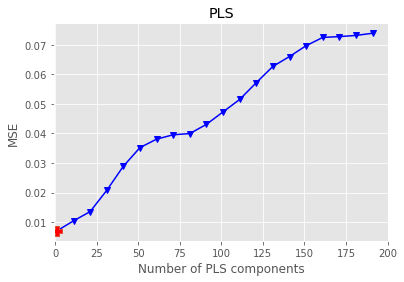

R2 calib: 0.027
R2 CV average: -0.082
MSE calib: 0.006
MSE CV average: 0.007


In [24]:
optimise_pls_cv(X2,y2, 200, plot_components=True)

In [25]:
pls = PLSRegression(n_components=3)
model_pls = pls.fit(X2_train, y2_train)

y_c = model_pls.predict(X2_test)


In [26]:
# Cross-validation
y_cv = cross_val_predict(model_pls, X2_test, y2_test, cv=10)


# Calculate scores for calibration and cross-validation
score_c = r2_score(y2_test, y_c)
score_cv = r2_score(y2_test, y_cv)


# Calculate mean squared error for calibration and cross validation
mse_c = mean_squared_error(y2_test, y_c)
mse_cv = mean_squared_error(y2_test, y_cv)

print('R2: %5.3f'  % score_c)
print('R2 CV: %5.3f'  % score_cv)
print('MSE: %5.3f' % mse_c)
print('MSE CV average: %5.3f' % mse_cv)


R2: -0.458
R2 CV: -0.372
MSE: 0.008
MSE CV average: 0.008


### PLS2: multivariate target
PLS canonical

In [27]:

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 42)

In [28]:
plsca = PLSCanonical(n_components=len(target_features))
model_pls_canonical = plsca.fit(X2_train, Y2_train)
X_c, Y_c = plsca.transform(X2_test, Y2_test)


# Cross-validation
#Y_cv = cross_val_predict(model_pls_canonical, X2_test, y2_test, cv=10)

In [31]:

# Calculate scores for calibration and cross-validation
plsca_score_c = r2_score(Y2_test, Y_c)

# Calculate mean squared error for calibration and cross validation
plsca_mse_c = mean_squared_error(Y2_test, Y_c)

print('R2: %5.3f'  % plsca_score_c)

print('MSE: %5.3f' % plsca_mse_c)


R2: -3231.744
MSE: 1.292


### 3.3 Random forest regression

In [40]:

X2, y2 = make_regression(n_features=len(wavelenghts), n_informative=150,random_state=0, shuffle=False)

rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X2_train, y2_train)
y_pred_rf = regr.predict(X2_test)#.reshape(1, 1))

# Calculate scores for calibration and cross-validation
rf_score_c = r2_score(y2_test, y_pred_rf)

# Calculate mean squared error for calibration and cross validation
rf_mse_c = mean_squared_error(y2_test, y_pred_rf)

print('R2: %5.3f'  % rf_score_c)

print('MSE: %5.3f' % rf_mse_c)


<ipython-input-40-1549d06412be>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X2_train, y2_train)


R2: -0.426
MSE: 0.008


### 3.4 Gradient Boost regression

In [53]:
params = {'n_estimators': 500,
          'max_depth': 10,
          'min_samples_split': 5,
          'learning_rate': 0.001,
          'loss': 'ls'}

GBreg = GradientBoostingRegressor(**params)
GBreg.fit(X2_train, y2_train)

y_pred_gb = GBreg.predict(X2_test)

xg_score_c = r2_score(y2_test, y_pred_gb)

mse = mean_squared_error(y2_test, y_pred_gb)

print('R2: %5.3f'  % xg_score_c)

print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


R2: -0.254
The mean squared error (MSE) on test set: 0.0069


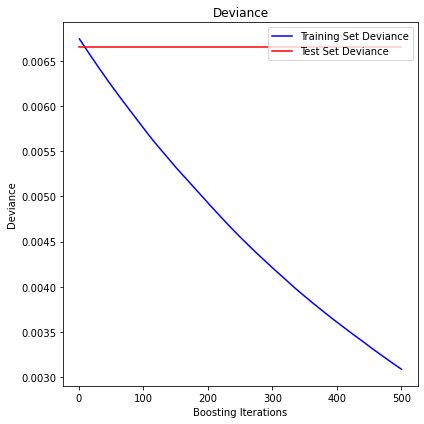

In [55]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(GBreg.staged_predict(X2_test)):
    test_score[i] = GBreg.loss_(y2_test, y_pred_gb)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, GBreg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()